Paul Gasper, Ph.D., National Renewable Energy Lab, 2024

Paul.Gasper@nrel.gov

Examples of simulating EV lifetime for personal and commercial vehicles based on assumed driving profiles.
These simulations are not meant to comment on real-world EVs. Battery life models are dependent on battery-specific degradation data, and the driving profiles were created as illustrative examples and are not representative of real world driving data.

The climate chosen in this example is Honolulu, Hawai'i, which has a very stable climate in a temperature range that is optimal for many commercial lithium-ion batteries. As this simulation is not addressing thermal management of the vehicle battery in any way, any simulations for climates with extreme heat or extreme cold will not be an accurate representation of most real world EVs, which can cool and sometimes heat the battery pack to maintain safe and reliable battery performance in a wide temperature range.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from blast.utils.functions import get_nsrdb_temperature_data

Found location:  Honolulu, Honolulu County, Hawaii, United States
Input coordiantes: 	 (21.304547, -157.855676)
Coordinates of nearest point in NSRDB: 	 [  21.29 -157.86]


Text(0, 0.5, 'Temperature (C)')

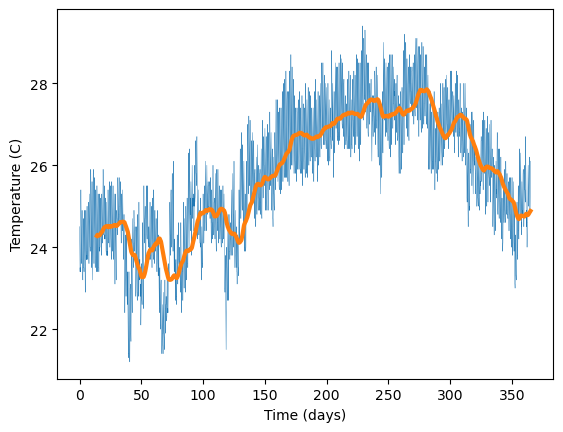

In [2]:
climate = get_nsrdb_temperature_data('Honolulu, Hawaii')
plt.plot(climate['Time_s']/(3600*24), climate['Temperature_C'], linewidth=0.3)
plt.plot(climate['Time_s']/(3600*24), climate['Temperature_C'].rolling(14*24*2).mean(), linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Temperature (C)')

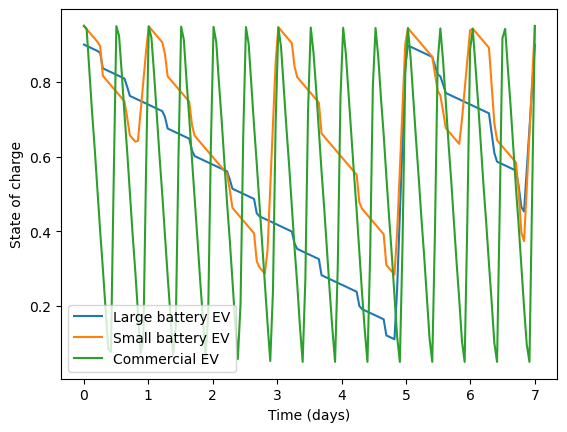

In [3]:
ev_largebattery = pd.read_csv('application profiles/personal_ev_largebatt.csv')
ev_largebattery = ev_largebattery.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

ev_smallbattery = pd.read_csv('application profiles/personal_ev_smallbatt.csv')
ev_smallbattery = ev_smallbattery.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

commercial_ev = pd.read_csv('application profiles/commercial_ev.csv')
commercial_ev = commercial_ev.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

plt.plot(ev_largebattery['Time_s'] / (24*3600), ev_largebattery['SOC'], label='Large battery EV')
plt.plot(ev_smallbattery['Time_s'] / (24*3600), ev_smallbattery['SOC'], label='Small battery EV')
plt.plot(commercial_ev['Time_s'] / (24*3600), commercial_ev['SOC'], label='Commercial EV')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

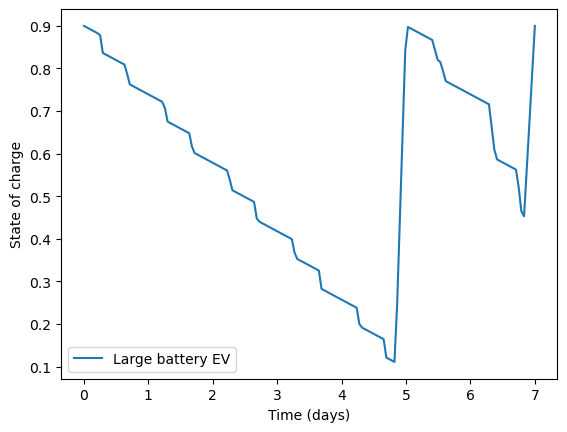

In [4]:
plt.plot(ev_largebattery['Time_s'] / (24*3600), ev_largebattery['SOC'], label='Large battery EV')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

In [5]:
from blast.utils.functions import assemble_one_year_input
input_ev_smallbatt = assemble_one_year_input(ev_smallbattery, climate)
input_ev_largebatt = assemble_one_year_input(ev_largebattery, climate)
input_ev_commercial = assemble_one_year_input(commercial_ev, climate)

c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\degradation_model.py:502: RuntimeWarning: invalid value encountered in scalar divide
  Crate = np.trapz(abs_instantaneous_crate, t_days[1:]) / delta_t_days
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:158: RuntimeWarning: invalid value encountered in scalar divide
  q1 = np.trapz(q1, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:159: RuntimeWarning: invalid value encountered in scalar divide
  q3 = np.trapz(q3, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:160: RuntimeWarning: invalid value encountered in scalar divide
  q5 = np.trapz(q5, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\

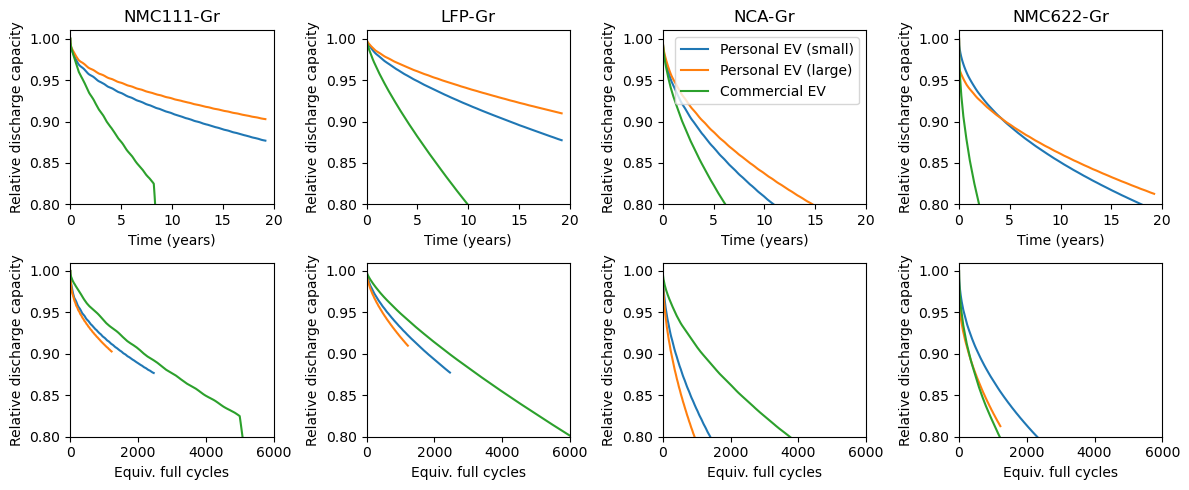

In [ ]:
from blast.models.nmc111_gr_Kokam75Ah_2017 import Nmc111_Gr_Kokam75Ah_Battery
from blast.models.lfp_gr_250AhPrismatic_2019 import Lfp_Gr_250AhPrismatic
from blast.models.nca_gr_Panasonic3Ah_2018 import Nca_Gr_Panasonic3Ah_Battery
from blast.models.nmc622_gr_DENSO50Ah_2021 import Nmc622_Gr_DENSO50Ah_Battery

batteries = {
    'NMC111-Gr': [Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery()],
    'LFP-Gr': [Lfp_Gr_250AhPrismatic(), Lfp_Gr_250AhPrismatic(), Lfp_Gr_250AhPrismatic()],
    'NCA-Gr': [Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery()],
    'NMC622-Gr': [Nmc622_Gr_DENSO50Ah_Battery(), Nmc622_Gr_DENSO50Ah_Battery(), Nmc622_Gr_DENSO50Ah_Battery()]
}
simulations = {
    'Personal EV (small)': input_ev_smallbatt,
    'Personal EV (large)': input_ev_largebatt,
    'Commercial EV': input_ev_commercial,
}

years_simulation = 20
fig, ax = plt.subplots(2, 4, figsize=(12,5))
idx_ax = 0
for batt_type, battery in batteries.items():
    idx_sim = 0
    for sim_type, sim_input in simulations.items():
        batt = battery[idx_sim]
        batt.simulate_battery_life(sim_input, threshold_time=years_simulation)

        ax[0][idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=sim_type)
        ax[1][idx_ax].plot(batt.stressors['efc'], batt.outputs['q'], label=sim_type)
        idx_sim += 1
        
    ax[0][idx_ax].set_xlabel('Time (years)')
    ax[0][idx_ax].set_ylabel('Relative discharge capacity')
    ax[0][idx_ax].set_ylim((0.8, 1.01))
    ax[0][idx_ax].set_xlim((0, 20))
    ax[1][idx_ax].set_xlabel('Equiv. full cycles')
    ax[1][idx_ax].set_ylabel('Relative discharge capacity')
    ax[1][idx_ax].set_ylim((0.8, 1.01))
    ax[1][idx_ax].set_xlim((0, 6000))

    ax[0][idx_ax].set_title(batt_type)
    if idx_ax == 2:
        ax[0][idx_ax].legend(loc='upper right')
    idx_ax += 1

plt.tight_layout()

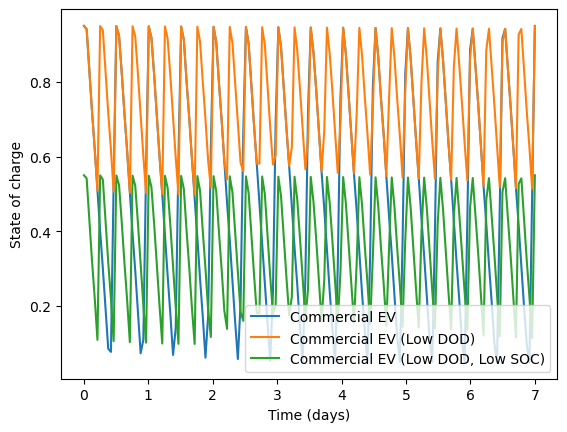

In [8]:
commercial_ev_lowdod = pd.read_csv('application profiles/commercial_ev_lowdod.csv')
commercial_ev_lowdod = commercial_ev_lowdod.iloc[np.linspace(0, 24*3600*7 - 1, 24*7)]

commercial_ev_lowdod_lowsoc = commercial_ev_lowdod.copy()
commercial_ev_lowdod_lowsoc['SOC'] += -0.4

plt.plot(commercial_ev['Time_s'] / (24*3600), commercial_ev['SOC'], label='Commercial EV')
plt.plot(commercial_ev_lowdod['Time_s'] / (24*3600), commercial_ev_lowdod['SOC'], label='Commercial EV (Low DOD)')
plt.plot(commercial_ev_lowdod_lowsoc['Time_s'] / (24*3600), commercial_ev_lowdod_lowsoc['SOC'], label='Commercial EV (Low DOD, Low SOC)')
plt.xlabel('Time (days)')
plt.ylabel('State of charge')
plt.legend()

c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\degradation_model.py:502: RuntimeWarning: invalid value encountered in scalar divide
  Crate = np.trapz(abs_instantaneous_crate, t_days[1:]) / delta_t_days
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:158: RuntimeWarning: invalid value encountered in scalar divide
  q1 = np.trapz(q1, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:159: RuntimeWarning: invalid value encountered in scalar divide
  q3 = np.trapz(q3, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\models\nmc111_gr_Kokam75Ah_2017.py:160: RuntimeWarning: invalid value encountered in scalar divide
  q5 = np.trapz(q5, x=t_secs) / delta_t_secs
c:\Users\pgasper\AppData\Local\anaconda3\envs\blast-lite\Lib\site-packages\blast\

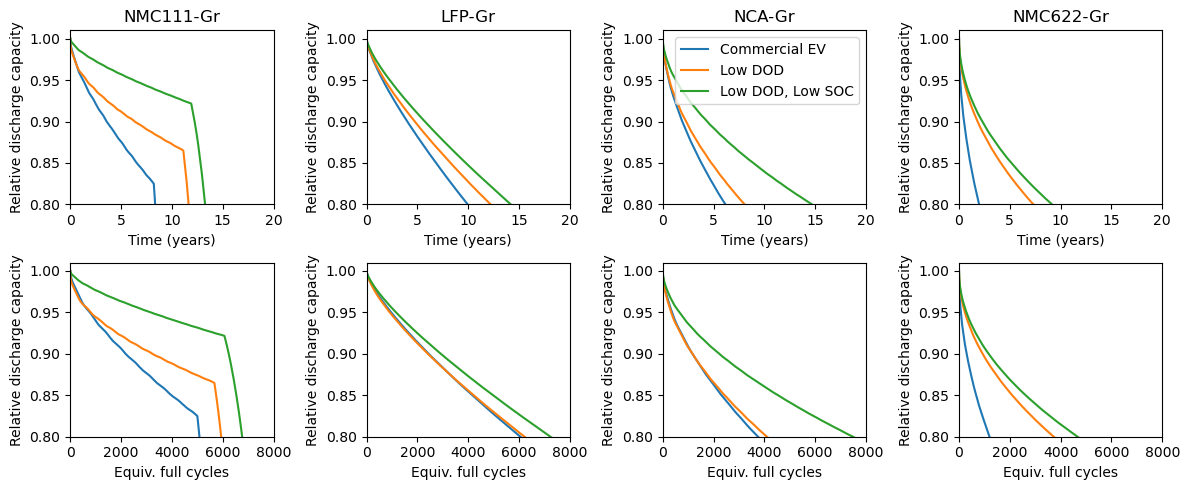

In [ ]:
input_ev_commercial_lowdod = assemble_one_year_input(commercial_ev_lowdod, climate)
input_ev_commercial_lowdod_lowsoc = assemble_one_year_input(commercial_ev_lowdod_lowsoc, climate)

batteries = {
    'NMC111-Gr': [Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery(), Nmc111_Gr_Kokam75Ah_Battery()],
    'LFP-Gr': [Lfp_Gr_250AhPrismatic(), Lfp_Gr_250AhPrismatic(), Lfp_Gr_250AhPrismatic()],
    'NCA-Gr': [Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery(), Nca_Gr_Panasonic3Ah_Battery()],
    'NMC622-Gr': [Nmc622_Gr_DENSO50Ah_Battery(), Nmc622_Gr_DENSO50Ah_Battery(), Nmc622_Gr_DENSO50Ah_Battery()]
}
simulations = {
    'Commercial EV': input_ev_commercial,
    'Low DOD': input_ev_commercial_lowdod,
    'Low DOD, Low SOC': input_ev_commercial_lowdod_lowsoc,
}

years_simulation = 20
fig, ax = plt.subplots(2, 4, figsize=(12,5))
idx_ax = 0
for batt_type, battery in batteries.items():
    idx_sim = 0
    for sim_type, sim_input in simulations.items():
        batt = battery[idx_sim]
        batt.simulate_battery_life(sim_input, threshold_time=years_simulation)

        ax[0][idx_ax].plot(batt.stressors['t_days']/365, batt.outputs['q'], label=sim_type)
        ax[1][idx_ax].plot(batt.stressors['efc'], batt.outputs['q'], label=sim_type)
        idx_sim += 1
        
    ax[0][idx_ax].set_xlabel('Time (years)')
    ax[0][idx_ax].set_ylabel('Relative discharge capacity')
    ax[0][idx_ax].set_ylim((0.8, 1.01))
    ax[0][idx_ax].set_xlim((0, 20))
    ax[1][idx_ax].set_xlabel('Equiv. full cycles')
    ax[1][idx_ax].set_ylabel('Relative discharge capacity')
    ax[1][idx_ax].set_ylim((0.8, 1.01))
    ax[1][idx_ax].set_xlim((0, 8000))

    ax[0][idx_ax].set_title(batt_type)
    if idx_ax == 2:
        ax[0][idx_ax].legend(loc='upper right')
    idx_ax += 1

plt.tight_layout()